In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import glob
import numpy as np
import scipy.misc

import keras
import keras.callbacks
import keras.backend as K
from keras import optimizers
from keras.engine.topology import Layer
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, Concatenate,Lambda, Conv2D, MaxPooling2D, Flatten, Multiply

from keras.models import Model
from collections import OrderedDict
from tqdm import trange, tqdm

import tensorflow as tf
from tensorflow import image as tfi

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# - Utils

In [8]:
def get_image_data(img_path, image_size, space='rgb'):
    if space=='rgb':
        img = image.load_img(img_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return x[0]
    elif space=='gray':
        img = image.load_img(img_path, target_size=image_size, grayscale=True)
        x = image.img_to_array(img)
        x /= 255.
        return x

class MySigmoidLayer(Layer):
    def __init__(self, **kwargs):
        super(MySigmoidLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, 1),
                                      initializer='uniform',
                                      trainable=True)
        super(MySigmoidLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return 1./(1.+K.exp(-(x-0.5)*self.kernel))

    def compute_output_shape(self, input_shape):
        return input_shape
    
def create_weighted_model():
    vgg16_1 = VGG16(include_top=False, weights='imagenet', input_shape=(600, 800, 3))
    vgg16_2 = VGG16(include_top=False, weights='imagenet', input_shape=(300, 400, 3))
    for layer in vgg16_2.layers:
        layer.name = layer.name + "_sec"
    vgg16_2_output = Lambda(lambda x_: tf.image.resize_images(x_, (18, 25)),name="lambda_c1")(vgg16_2.get_layer("block5_pool_sec").output)
    x = Concatenate(name="my_concat")([vgg16_1.get_layer("block5_pool").output, vgg16_2_output])
    x = Lambda(lambda x_: tf.divide(x_, 255.), name="lambda_concate")(x)
    
    pooled_output = MaxPooling2D(pool_size=(2, 2))(x)
    flatted_output = Flatten()(pooled_output)
    weight_layer = Dense(1024)(flatted_output)

    weighted_neuron = Multiply()([x, weight_layer])
    
    sal_output = Conv2D(1, (1, 1), strides=(1, 1), padding='valid', use_bias=True)(weighted_neuron)
    sal_output = MySigmoidLayer()(sal_output)
    
    new_model = Model(inputs=[vgg16_1.input, vgg16_2.input], outputs=sal_output)
    
    return new_model

# - Testing

In [10]:
model = create_weighted_model()
model.load_weights('train_output/salicon_generator_epoch_sigmoid25.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6_sec (InputLayer)        (None, 300, 400, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 600, 800, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1_sec (Conv2D)       (None, 300, 400, 64) 1792        input_6_sec[0][0]                
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 600, 800, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
block1_con

  0%|          | 0/1 [00:00<?, ?it/s]/home/dlnus/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


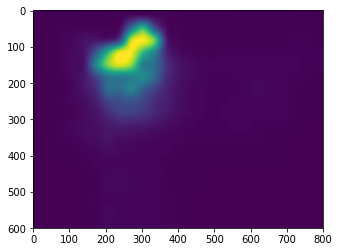

100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


In [11]:
images = sorted(glob.glob('./datasets/MIT300/*.jpg'))[0:1]
for ind, img,in enumerate(tqdm(images)):
    name = os.path.basename(img)
    x1 = np.expand_dims(get_image_data(img, (600, 800), space="rgb"), axis=0)
    x2 = np.expand_dims(get_image_data(img, (300, 400), space="rgb"), axis=0)
    res = model.predict([x1, x2])
    sal = scipy.misc.imresize(res[0,:,:,0], (600, 800), interp='bicubic')
    plt.imshow(sal)
    plt.show()